# Image enhancement using an encoder-decoder CNN
The goal of this notebook is to use an encoder-decoder CNN model to deblock and enhance JPEG-compressed images.

## Preparation


### Kaggle

In [1]:
#!rm -rf /content/dataset; rm -rf /content/training; rm -rf ~/.kaggle

In [1]:
import os
import getpass

kaggle_ids = getpass.getpass('Content of your ~/.kaggle/kaggle.json: ')
os.environ['KAGGLE_JSON'] = kaggle_ids

!mkdir ~/.kaggle; echo $KAGGLE_JSON > ~/.kaggle/kaggle.json; chmod 600 ~/.kaggle/kaggle.json

Content of your ~/.kaggle/kaggle.json:  ········


### Downloading and compressing images



In [2]:
!pip install -qq kaggle
!mkdir /content/dataset
!kaggle datasets download -d arnaud58/landscape-pictures -p /content/dataset --unzip
#kaggle datasets download -d farhanhaikhan/general-purpose-image-dataset -p /content/dataset --unzip; mv /content/dataset/dataset/* /content/dataset/

 99%|███████████████████████████████████████▊| 617M/620M [00:18<00:00, 39.2MB/s]
100%|████████████████████████████████████████| 620M/620M [00:18<00:00, 34.5MB/s]


In [1]:
!pip install -qq numpy Pillow
import io
import pathlib
import numpy as np
import tensorflow as tf
from PIL import Image
from itertools import chain
from keras.utils import load_img, img_to_array


img_width, img_height = 256, 256


def img_buffer_to_array(buffer):
    return img_to_array(load_img(buffer, target_size=(img_width, img_height), keep_aspect_ratio=True)) / 255.0

def process_images_for_training(src_directory, dest_directory, quality_factor=5):
    folder = pathlib.Path(src_directory).resolve()
    extensions = {'*.jpg', '*/*.jpg', '*.jpeg', '*/*.jpeg'}
    images = set(chain.from_iterable(folder.glob(ext) for ext in extensions))

    nb_img, nb_errors, nb_wrongsize = len(images), 0, 0
    print(f'Found {nb_img} images.')

    for i, image_file in enumerate(images):
        try:
            im = Image.open(image_file)
        except OSError:
            nb_errors += 1
            continue

        if im.width < img_width or im.height < img_height:
            nb_wrongsize += 1
            continue

        quality_buffer = io.BytesIO()
        compressed_buffer = io.BytesIO()

        im.save(quality_buffer, format='JPEG', optimize=True, quality=100)
        im.save(compressed_buffer, format='JPEG', optimize=False, quality=quality_factor)

        np.savez(f'{dest_directory}/{i}.npz', quality=img_buffer_to_array(quality_buffer), compressed=img_buffer_to_array(compressed_buffer))

        if i % 250 == 0:
            progress = i / nb_img * 100
            print(f'{progress:.2f}% ({i}/{nb_img} WS={nb_wrongsize} E={nb_errors})')

    print('Done.')
    return nb_img - nb_errors - nb_wrongsize


In [2]:
!rm -rf /content/training; mkdir /content/training
process_images_for_training('/content/dataset', '/content/training', quality_factor=7)

Found 4319 images.
0.00% (0/4319 WS=0 E=0)
5.79% (250/4319 WS=1 E=0)
11.58% (500/4319 WS=1 E=0)
17.37% (750/4319 WS=2 E=0)
23.15% (1000/4319 WS=2 E=0)
28.94% (1250/4319 WS=4 E=0)
34.73% (1500/4319 WS=4 E=0)
40.52% (1750/4319 WS=4 E=0)
46.31% (2000/4319 WS=4 E=0)
52.10% (2250/4319 WS=4 E=0)
57.88% (2500/4319 WS=5 E=0)
63.67% (2750/4319 WS=5 E=0)
69.46% (3000/4319 WS=5 E=0)
75.25% (3250/4319 WS=7 E=0)
81.04% (3500/4319 WS=7 E=0)
86.83% (3750/4319 WS=8 E=0)
92.61% (4000/4319 WS=8 E=0)
98.40% (4250/4319 WS=8 E=0)
Done.


4311

## Building our data pipeline
Instead of loading all the dataset in memory, we'll use a generator that yields pairs of images, the compressed one to make the prediction on and the ground truth.

### Creating the dataset

In [3]:
import pathlib

BATCH_SIZE = 32
NB_FILES = len(set(pathlib.Path('/content/training').glob('*.npz')))
SPE = int(NB_FILES / BATCH_SIZE)
print(f"Batch size: {BATCH_SIZE}\n{NB_FILES} samples\nSPE: {SPE}")

Batch size: 32
4311 samples
SPE: 134


In [4]:
!pip install -qq tensorflow-addons
import random
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa


def random_augmentation(image_1, image_2):
    rand_1, rand_2, rand_3 = (float(tf.random.uniform(())) for _ in range(3))

    if rand_1 < 0.5:
        image_1 = tf.image.flip_left_right(image_1)
        image_2 = tf.image.flip_left_right(image_2)

    if rand_2 < 0.5:
        image_1 = tf.image.flip_up_down(image_1)
        image_2 = tf.image.flip_up_down(image_2)

    if rand_3 < 0.5:
        angle = rand_3 * 90
        image_1 = tfa.image.rotate(image_1, angle, fill_mode='reflect')
        image_2 = tfa.image.rotate(image_2, angle, fill_mode='reflect')

    return image_1, image_2

def images_generator(path, *args):
    files = sorted(pathlib.Path(path.decode()).glob("*.npz"))

    for f in files:
        pair = np.load(f)
        yield pair['compressed'], pair['quality']

def get_dataset(sources):
    spec = tf.data.Dataset.from_generator(images_generator, args=sources, output_signature=(
        tf.TensorSpec(shape=(None, None, 3)), tf.TensorSpec(shape=(None, None, 3)),
    ))
    return spec.cache().repeat().shuffle(BATCH_SIZE * 10, reshuffle_each_iteration=True).map(random_augmentation, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(1)


dataset_training = get_dataset([b'/content/training/'])

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usin

### Display dataset

2023-11-03 21:02:59.845191: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


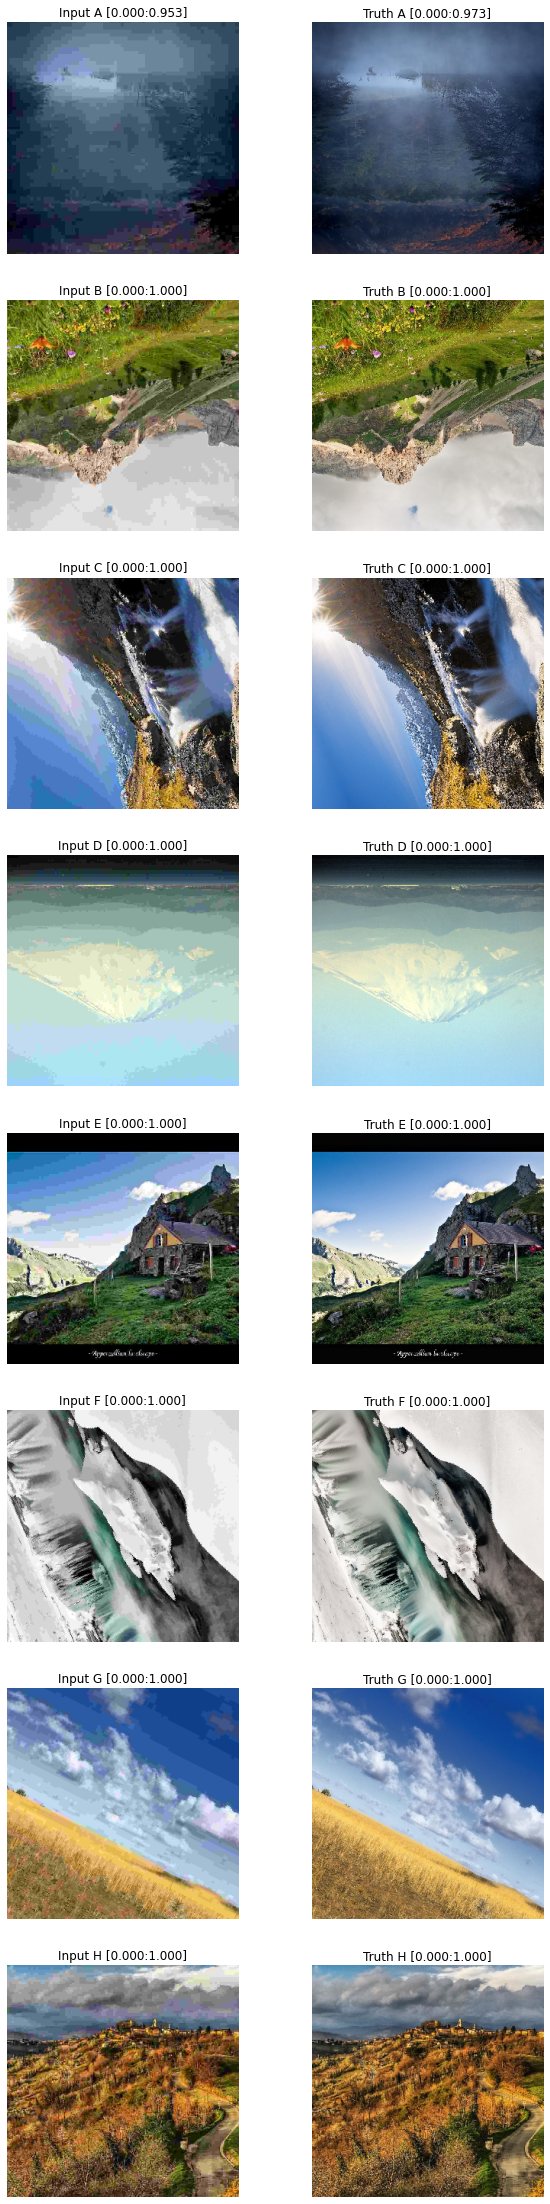

In [8]:
!pip install -qq matplotlib
import string
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import array_to_img


batch = list(dataset_training.take(1).as_numpy_iterator())
batchX, batchY = batch[0][0], batch[0][1]
choices = zip(range(8), string.ascii_uppercase)

plt.figure(figsize=(2 * 5, 8 * 5))

for i, l in choices:
    x = batchX[i]
    pixmin, pixmax = np.min(x), np.max(x)
    img = array_to_img(x * 255.0, scale=False)
    plt.subplot(8, 2, i*2 + 1)
    plt.imshow(img)
    plt.title(f'Input {l} [{pixmin:.3f}:{pixmax:.3f}]')
    plt.axis('off')

    y = batchY[i]
    pixmin, pixmax = np.min(y), np.max(y)
    img = array_to_img(y * 255.0, scale=False)
    plt.subplot(8, 2, i*2 + 2)
    plt.imshow(img)
    plt.title(f'Truth {l} [{pixmin:.3f}:{pixmax:.3f}]')
    plt.axis('off')

## Building the model
The design of the model is a standard encoder-decoder.

We'll use SSIM as our loss function to try and maximise image similarity between prediction and truth. We'll also monitor PSNR as an additional indicator.

In [5]:
!rm -f /tmp/*.h5; rm -f /tmp/*.py

import tempfile
import keras.backend as K
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.constraints import max_norm


xargs = dict(padding='same', kernel_initializer='he_uniform')

model = Sequential([
    layers.Conv2D(128, (3, 3), strides=2, input_shape=(img_width, img_height, 3), **xargs),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2D(256, (3, 3), strides=2, **xargs),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2D(512, (3, 3), strides=2, **xargs),
    layers.LeakyReLU(alpha=0.2),


    layers.Conv2DTranspose(512, (3, 3), strides=2, **xargs),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2DTranspose(256, (3, 3), strides=2, **xargs),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2DTranspose(128, (3, 3), strides=2, **xargs),
    layers.LeakyReLU(alpha=0.2),

    layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'),
])

def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def custom_loss(y_true, y_pred):
    alpha = 0.8
    ssim_loss = (1 - tf.image.ssim(y_true, y_pred, max_val=1.0))
    mae_loss = tf.reduce_mean(tf.abs((y_true) - (y_pred)))
    loss = (alpha * ssim_loss + (1-alpha) * mae_loss)
    return tf.reduce_mean(loss)


model.compile(loss=custom_loss,
              metrics=[keras.losses.MAE, PSNR, SSIM],
              optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 256)      1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 512)       1180160   
                                                        

## Training

In [6]:
_, checkpoint_train = tempfile.mkstemp(prefix='training_', suffix='.h5', dir='/tmp')
checkpoint_t = keras.callbacks.ModelCheckpoint(checkpoint_train, monitor='loss', save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(patience=5, monitor='loss', restore_best_weights=True)

training = model.fit(dataset_training, epochs=50, steps_per_epoch=SPE, callbacks=(checkpoint_t, early_stop))

Epoch 1/50


2023-11-06 19:25:19.597861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


134/134 [==============================] - 114s 751ms/step - loss: 0.3261 - mean_absolute_error: 0.0916 - PSNR: 19.0426 - SSIM: 0.6153
Epoch 2/50
134/134 [==============================] - 16s 119ms/step - loss: 0.2217 - mean_absolute_error: 0.0578 - PSNR: 22.3790 - SSIM: 0.7374
Epoch 3/50
134/134 [==============================] - 17s 131ms/step - loss: 0.2015 - mean_absolute_error: 0.0531 - PSNR: 23.1330 - SSIM: 0.7614
Epoch 4/50
134/134 [==============================] - 18s 132ms/step - loss: 0.1924 - mean_absolute_error: 0.0509 - PSNR: 23.4967 - SSIM: 0.7722
Epoch 5/50
134/134 [==============================] - 17s 128ms/step - loss: 0.1896 - mean_absolute_error: 0.0519 - PSNR: 23.4150 - SSIM: 0.7759
Epoch 6/50
134/134 [==============================] - 17s 125ms/step - loss: 0.1840 - mean_absolute_error: 0.0490 - PSNR: 23.8566 - SSIM: 0.7822
Epoch 7/50
134/134 [==============================] - 17s 124ms/step - loss: 0.1834 - mean_absolute_error: 0.0482 - PSNR: 23.9640 - SSIM: 0.

dict_keys(['loss', 'mean_absolute_error', 'PSNR', 'SSIM'])


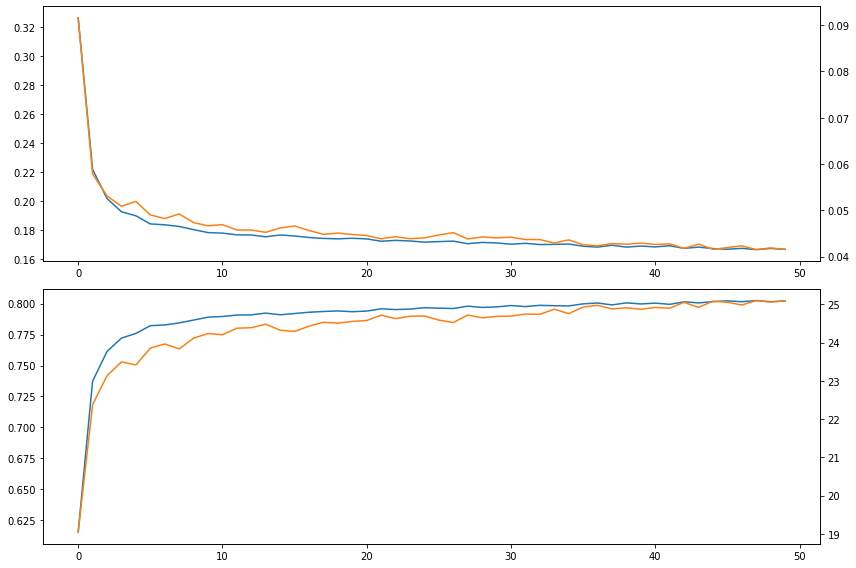

In [7]:
!pip install -qq matplotlib
from matplotlib import pyplot as plt

def plot_performance(history):
    print(history.history.keys())
    loss = history.history['loss']
    ssim = history.history['SSIM']
    psnr = history.history['PSNR']
    mae = history.history['mean_absolute_error']
    
    nb_epochs = len(loss)
    epochs_range = range(nb_epochs)

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 8))
    ax1.plot(epochs_range, loss, label='Loss', color='tab:blue')
    ax2 = ax1.twinx()
    ax2.plot(epochs_range, mae, label='MAE', color='tab:orange')
    
    ax3.plot(epochs_range, ssim, label='SSIM', color='tab:blue')
    ax4 = ax3.twinx()
    ax4.plot(epochs_range, psnr, label='PSNR', color='tab:orange')

    fig.tight_layout()
    plt.show()

plot_performance(getattr(locals(), 'training', None) or model.history)

1/1 [==============================] - 0s 24ms/step


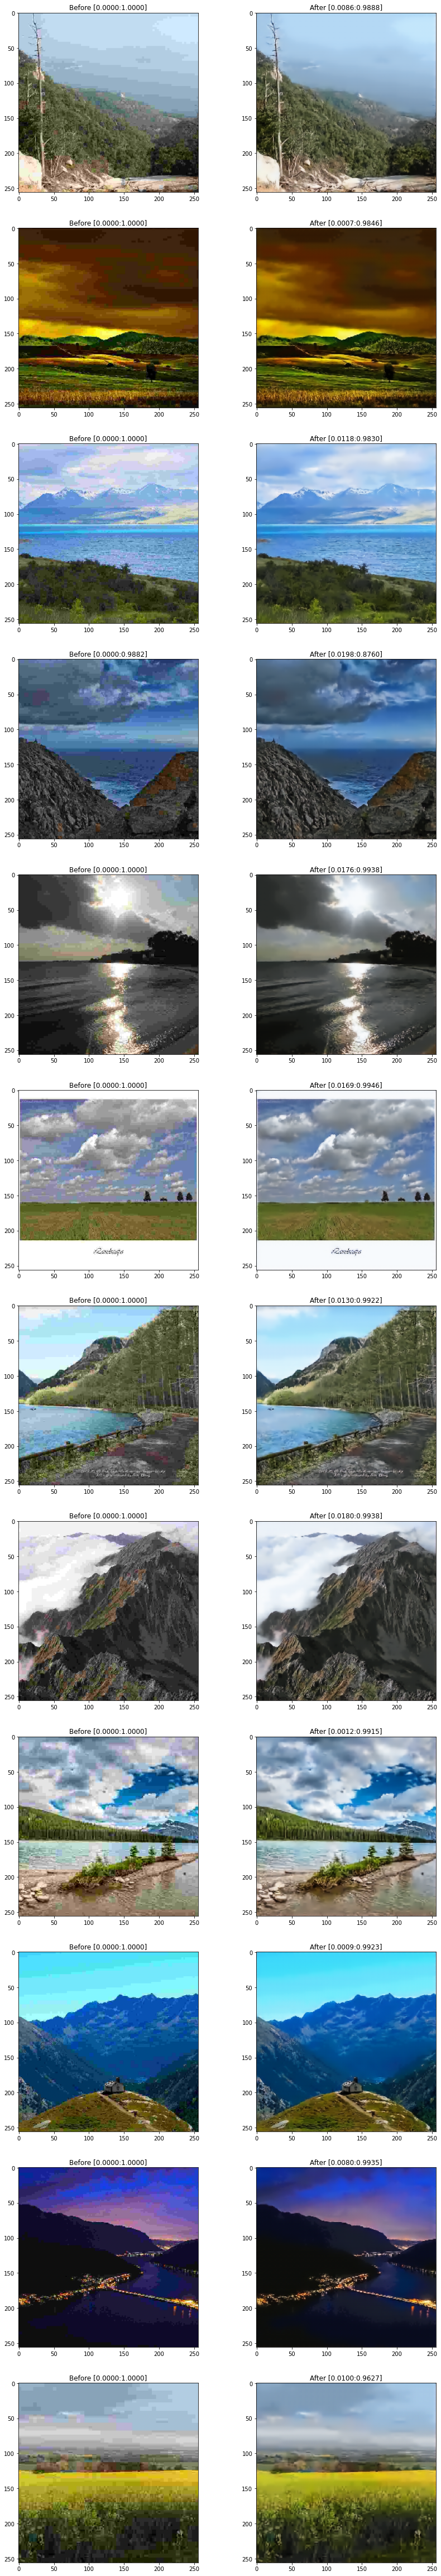

In [8]:
# @title Results { display-mode: "form" }
import random
import pathlib
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import load_img, img_to_array, array_to_img
from keras.models import Model


if 'checkpoint_train' in locals() and 'training' not in locals():
    print("Loading weights...")
    model.load_weights(checkpoint_train)

originals = random.sample(sorted(pathlib.Path('/content/training/').resolve().iterdir()), 12)
plt.figure(figsize=(14, 84))
i = 0

for original in originals:
    array = np.load(original)['compressed']

    batch = np.array([array])
    pred = model.predict(batch)

    img_1 = array_to_img(array * 255.0, scale=False)
    img_2 = array_to_img(pred[0] * 255.0, scale=False)

    plt.subplot(12, 2, i + 1)
    plt.imshow(img_1, interpolation=None)
    pixmin, pixmax = np.min(array), np.max(array)
    plt.title(f"Before [{pixmin:.4f}:{pixmax:.4f}]")
    plt.subplot(12, 2, i + 2)
    plt.imshow(img_2, interpolation=None)
    pixmin, pixmax = np.min(pred[0]), np.max(pred[0])
    plt.title(f"After [{pixmin:.4f}:{pixmax:.4f}]")

    i += 2


The results are quite good, all the blocking is gone while retaining most of the image detail.